## 02. Neural Network classification with Pytorch

Classification is a problem of predicting wether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

## 1. Make classification data and get ir ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.05, random_state=42)
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
First 5 samples of y: [1 1 1 1 0]


In [4]:
# Make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "y": y})
circles.head()

,X0,X1,y
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


In [5]:
# Visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='X0', ylabel='X1'>

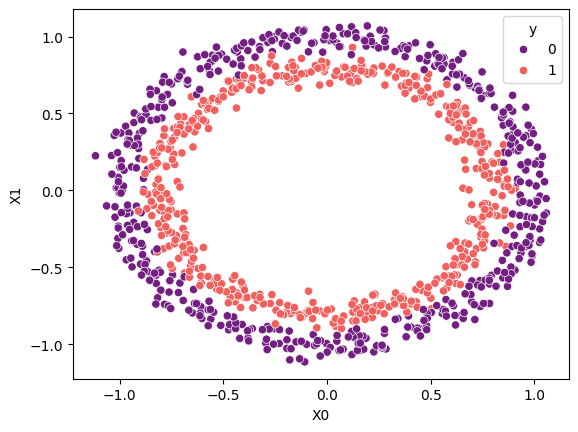

In [6]:
sns.scatterplot(x="X0", y="X1", hue="y", data=circles, palette="magma")

### 1.1 Check input and output shape

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels 
X_sample, y_sample = X[0], y[0]
X_sample, y_sample

(array([0.74220688, 0.24668576]), np.int64(1))

### 1.2 Getting our data into tensors and create train and test splits

In [9]:
import torch

In [10]:
type(X)

numpy.ndarray

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Building a model

Let's build a model to classify our pink and purple dots. To do so, we want to:

1. Setup device agnostic code so our code will run on gpu
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [15]:
import torch
from torch import nn

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
X_train

tensor([[ 0.6772, -0.4456],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        ...,
        [ 0.0011, -1.0504],
        [ 1.0259,  0.1799],
        [ 0.5597, -0.5673]])

Now that we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data 
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instatiate and instance of our model class and send it to the target `device`

In [18]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
	def _init_(self):
		super().__init__()
		# Create 2 nn.Linear layers capable of handling the shapes of our data
		self.layer1 = nn.Linear(in_features=2, out_features=5)# Generally, the more hidden features there are, the more opportunities our model has to learn patterns in the data
		self.layer2 = nn.Linear(in_features=5, out_features=1)

		# self.two_linear_layers = nn.Sequential(
		# 	nn.Linear(in_features=2, out_features=5),
		# 	nn.Linear(in_features=5, out_features=1)
		# )
	def forward(self, x):
		return self.layer2(self.layer1(x))# x-> layer1 -> layer2 -> output
		# return self.two_linear_layers(x)

# 4. Instantiate an instance of our model class and sent it to the target device 
model = CircleModelV0().to(device)
model

CircleModelV0()

In [19]:
model.parameters()

<generator object Module.parameters at 0x700cc0cc6f80>

In [20]:
# Let's replicate the model above using nn.Sequential()
model_0 =  nn.Sequential(
	nn.Linear(2, 5),
	nn.Linear(5, 1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5607, -0.6857],
                      [-0.0097, -0.0203],
                      [ 0.6978,  0.5252],
                      [ 0.6836, -0.5970],
                      [-0.4638, -0.4613]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1534,  0.2928, -0.1256, -0.4832, -0.4180], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1034,  0.4440,  0.0871,  0.1517,  0.0573]], device='cuda:0')),
             ('1.bias', tensor([-0.0198], device='cuda:0'))])

In [22]:
# Make predictions
with torch.inference_mode():
	untrained_preds = model_0(X_test.to(device))
print(f"Length of untrained_preds: {len(untrained_preds)} | shape: {untrained_preds.shape}")

Length of untrained_preds: 200 | shape: torch.Size([200, 1])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE.

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however, Pytorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`. For more what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/

* For different optimizers see `torch.optim`

In [23]:
# Setup the loss function
loss_fun = nn.BCEWithLogitsLoss() # Sigmoid function is included in this loss function

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [24]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

### 3.1 Going from raw logits to prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**. 

We can convert these **logits** into **prediction probability** by passing them to some kind of activation function(e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [25]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
	y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0475],
        [-0.0180],
        [-0.0628],
        [-0.0421],
        [ 0.0226]], device='cuda:0')

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits) # probs = probabilities
y_pred_probs

tensor([[0.4881],
        [0.4955],
        [0.4843],
        [0.4895],
        [0.5057]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5 , `y=0` (class 0) 

In [28]:
# Find the predicted labels 

y_preds = torch.round(y_pred_probs)

# In full(logits -> pred probs -> pred labels)
y_pred_lables = torch.round(torch.sigmoid(model_0(X_test.to(device))))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_lables.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

RuntimeError: The size of tensor a (5) must match the size of tensor b (200) at non-singleton dimension 0

### 3.2 Building a training and testing loop

At this point, I just wanted to know the part of computer vision, so I jumped to that part on the video. In the future I'll keep pn this part.

So I left this section on the 10:28:28 hours. The CV section start in the 14:00:48 hours